## Step 1
Inserting all necessary packages needed for this step

In [68]:
from utils import reshape_loaded_ds
from pathlib import Path
from matplotlib import pyplot as plt
from movement.io import load_poses
from movement.utils.reports import report_nan_values


Defining the file path for the data

In [69]:
data_folder = Path(r"C:\Users\Yousuf\Desktop\Project\Data")

plot_folder_0 = data_folder / "plots_thresholded"
plot_folder_0.mkdir(exist_ok=True)

plot_folder_1 = data_folder / "plots_interpolated"
plot_folder_1.mkdir(exist_ok=True)

plot_folder_2 = data_folder / "plots_smoothed"
plot_folder_2.mkdir(exist_ok=True)

clean_data_folder = data_folder / "clean_data"
clean_data_folder.mkdir(exist_ok=True)

report_folder = data_folder / "reports"
report_folder.mkdir(exist_ok=True)

In [70]:
file_name = "220719_SB019_FM001_female1_2022-07-19-164002DLC_resnet50_shanice_allNov29shuffle1_196000_filtered.csv"
file_name = data_folder / file_name


Reshaping the data in order to load into movement appropriately

In [71]:
ds = load_poses.from_dlc_file(file_name, fps=50)
all_keypoints = ds.keypoints.values

resident_keypoints = []
intruder_keypoints = []

for kp in all_keypoints:
    if kp.startswith("resident"):
        resident_keypoints.append(kp.split("_")[1])
    else:
        intruder_keypoints.append(kp.split("_")[1])
ds_new = reshape_loaded_ds(ds,["resident","intruder"],intruder_keypoints)
ds_new

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 3041, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 24kB 0.0 0.02 0.04 0.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 973kB 1.274e+0...
    confidence   (time, individuals, keypoints) float64 487kB 0.004567 ... 0....
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      C:/Users/Yousuf/Desktop/Project/Data/220719_SB019_FM001...

Selecting relevant time period from data

In [72]:
ds_new  = ds_new.sel(time=slice(34, 60.8))
ds_new

<xarray.Dataset> Size: 655kB
Dimensions:      (time: 1341, individuals: 2, keypoints: 10, space: 2)
Coordinates:
  * time         (time) float64 11kB 34.0 34.02 34.04 34.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 429kB 590.0 .....
    confidence   (time, individuals, keypoints) float64 215kB 0.3416 ... 0.9966
Attributes:
    fps:              50.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      C:/Users/Yousuf/Desktop/Project/Data/220719_SB019_FM001...

Plotting **position** data over time for all individuals and keypoints. 

In [73]:
position = ds_new.position
position

<xarray.DataArray 'position' (time: 1341, individuals: 2, keypoints: 10,
                              space: 2)> Size: 429kB
590.0 320.4 650.5 501.6 625.5 442.1 ... 825.0 555.7 831.3 609.1 767.5 579.6
Coordinates:
  * time         (time) float64 11kB 34.0 34.02 34.04 34.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'
  * space        (space) <U1 8B 'x' 'y'

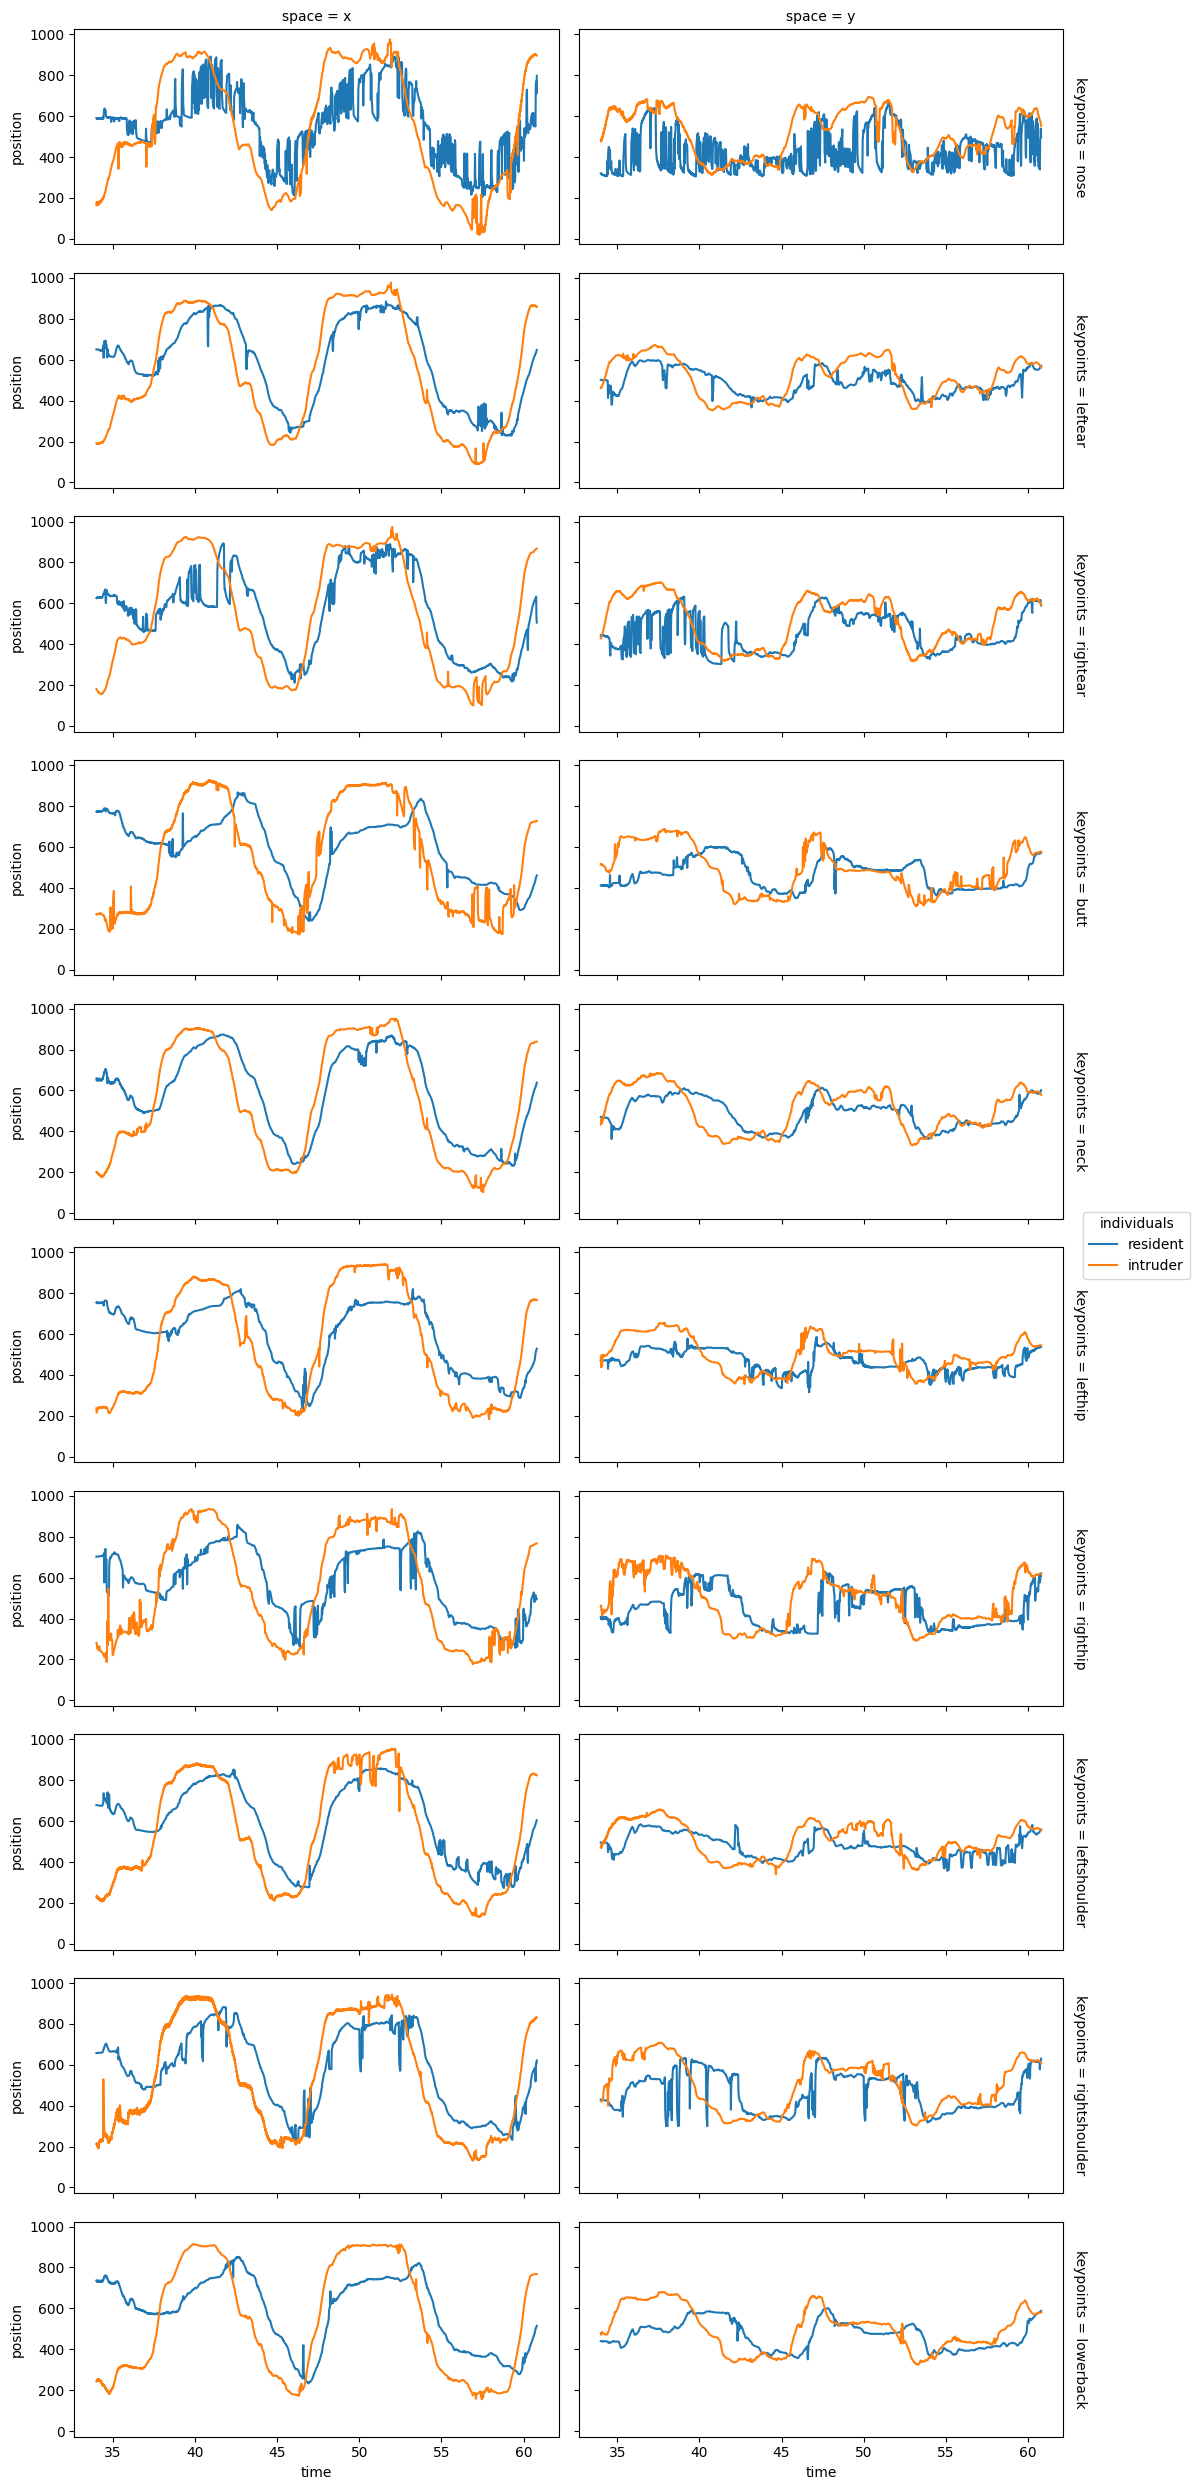

In [74]:
position.plot.line(x="time", row="keypoints",  hue="individuals", col="space", aspect=2, size=2.5)

Plotting **confidence** data with xarray for all individuals and keypoints

In [75]:
confidence = ds_new.confidence
confidence

<xarray.DataArray 'confidence' (time: 1341, individuals: 2, keypoints: 10)> Size: 215kB
0.3416 0.3254 0.9026 0.9968 0.9542 0.9167 ... 0.9974 0.8268 0.9805 0.4482 0.9966
Coordinates:
  * time         (time) float64 11kB 34.0 34.02 34.04 34.06 ... 60.76 60.78 60.8
  * individuals  (individuals) <U8 64B 'resident' 'intruder'
  * keypoints    (keypoints) <U13 520B 'nose' 'leftear' ... 'lowerback'

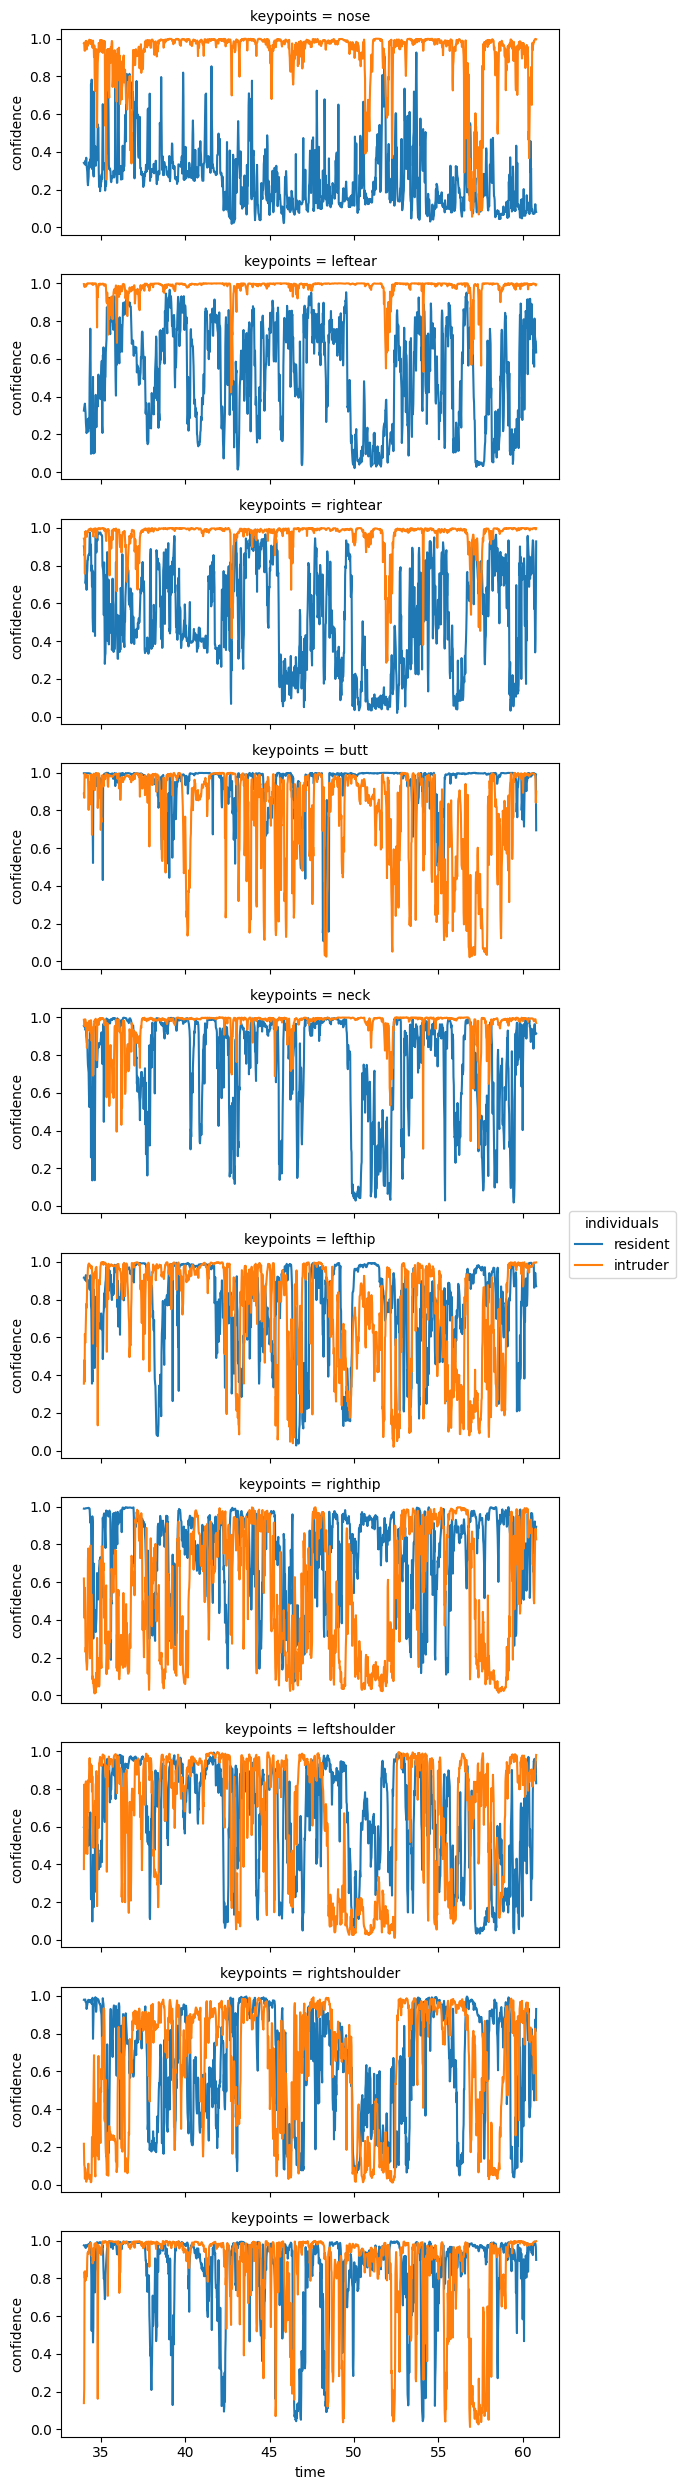

In [76]:
confidence.plot.line(x="time", row="keypoints",  hue="individuals", aspect=2, size=2.5)

## Step 2

Plotting confidence histograms for each individual

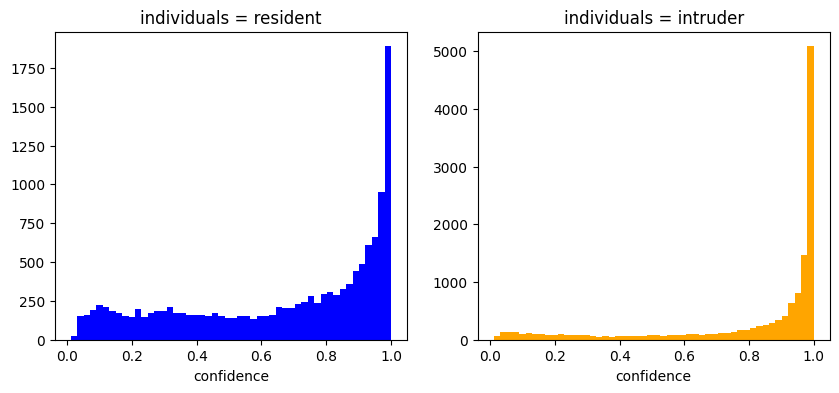

In [77]:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

colors = ["blue", "orange"]
for i, individual in enumerate(confidence.individuals.values):
    da = confidence.sel(individuals=individual)
    da.plot.hist(bins=50, alpha=1, label=individual, ax=ax[i], color=colors[i])



Plotting confidence histograms for each individual and keypoint

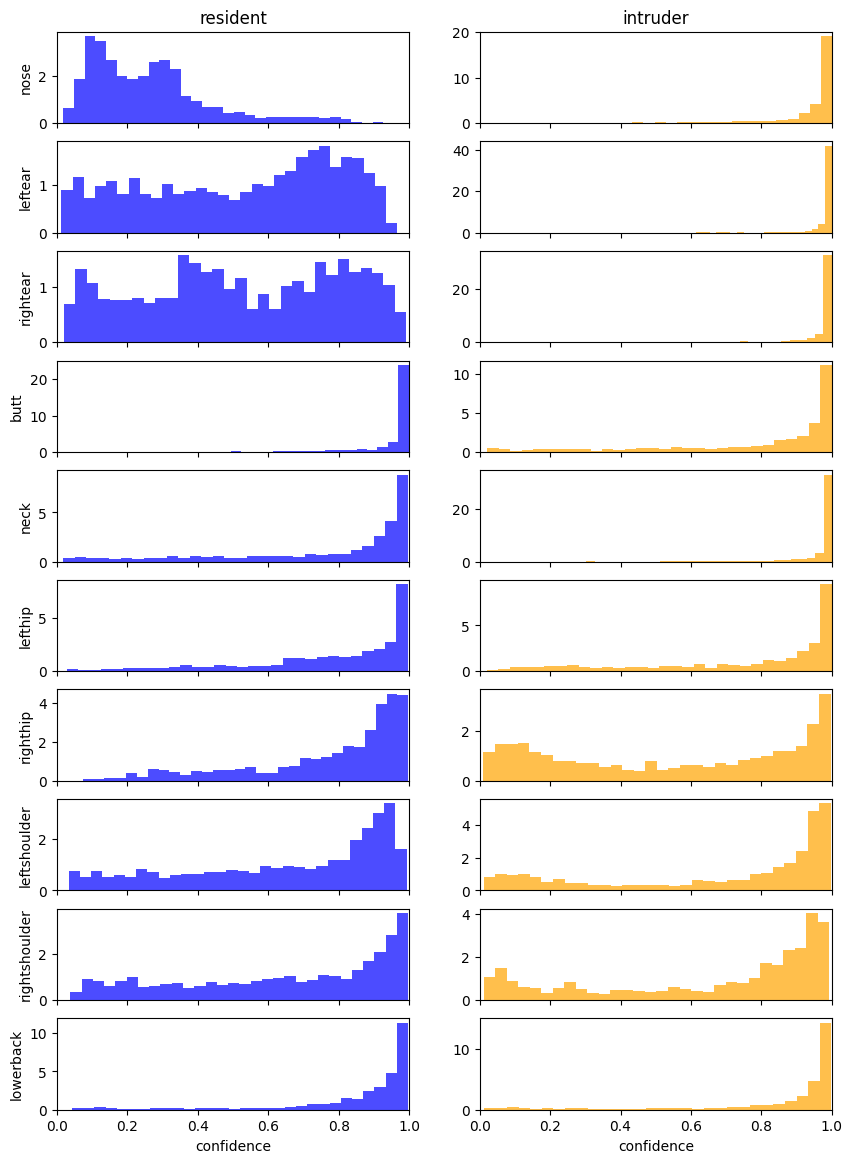

In [78]:
fig, ax = plt.subplots(figsize=(10,14), nrows=10, ncols=2, sharex=True)

colors = ["blue", "orange"]
for i, individual in enumerate(confidence.individuals.values):
    for j, keypoint in enumerate(confidence.keypoints.values):
        da = confidence.sel(keypoints=keypoint, individuals=individual)
        da.plot.hist(bins=30, alpha=0.7, label=keypoint, ax=ax[j, i], color=colors[i], density=True)
        ax[j, i].set_xlim([0, 1])
        ax[j, i].set_title(individual) if j == 0 else ax[j, i].set_title("")
        ax[j, i].set_ylabel(keypoint) if i == 0 else ax[j, i].set_ylabel("")
        ax[j, i].set_xlabel("confidence") if j==9 else ax[j, i].set_xlabel("")
            


Filtering data by confidence with set threshold


Missing points (marked as NaN) in input
	Individual: resident
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 0/1341 (0.0%)
		neck: 0/1341 (0.0%)
		lefthip: 0/1341 (0.0%)
		righthip: 0/1341 (0.0%)
		leftshoulder: 0/1341 (0.0%)
		rightshoulder: 0/1341 (0.0%)
		lowerback: 0/1341 (0.0%)
	Individual: intruder
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 0/1341 (0.0%)
		neck: 0/1341 (0.0%)
		lefthip: 0/1341 (0.0%)
		righthip: 0/1341 (0.0%)
		leftshoulder: 0/1341 (0.0%)
		rightshoulder: 0/1341 (0.0%)
		lowerback: 0/1341 (0.0%)

Missing points (marked as NaN) in output
	Individual: resident
		nose: 1329/1341 (99.1%)
		leftear: 1094/1341 (81.6%)
		rightear: 1049/1341 (78.2%)
		butt: 129/1341 (9.6%)
		neck: 499/1341 (37.2%)
		lefthip: 573/1341 (42.7%)
		righthip: 534/1341 (39.8%)
		leftshoulder: 760/1341 (56.7%)
		rightshoulder: 793/1341 (59.1%)
		lowerback: 286/1341 (21.3%)
	Individual: intruder
		nose: 156/1341 (11.6%)
		le

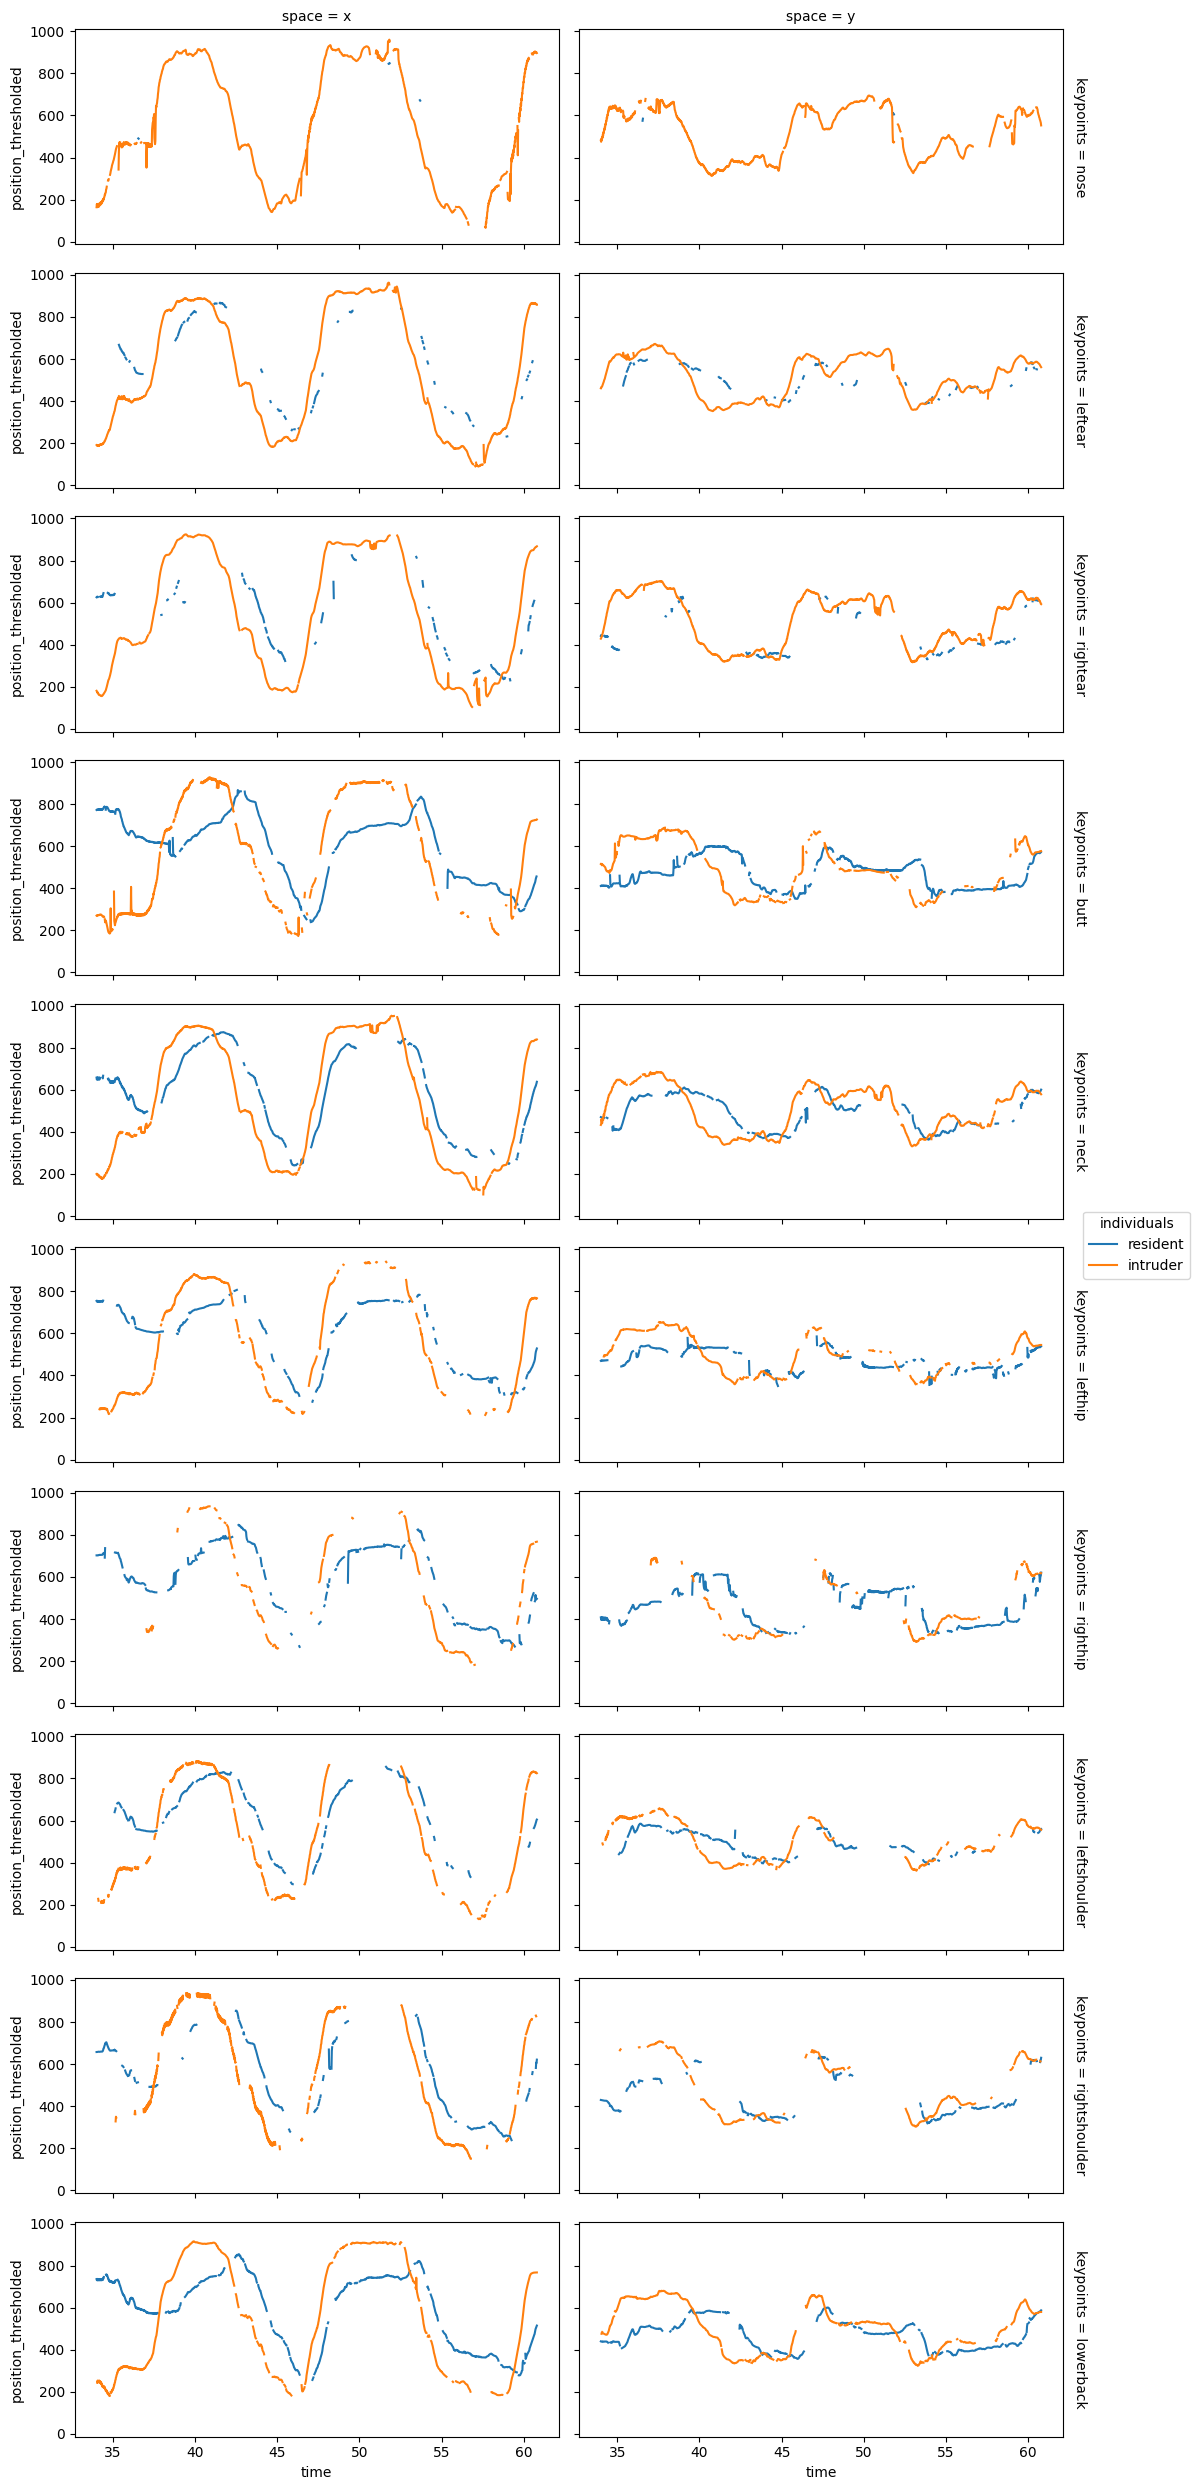

In [79]:
ds_new["position_thresholded"] = ds_new.move.filter_by_confidence(threshold=0.8)
ds_new["position_thresholded"].plot.line(x="time", row="keypoints",  hue="individuals", col="space", aspect=2, size=2.5)
plt.savefig(plot_folder_0 / "SB019_female1_position_threshold-80_max-gap-25.png")

Interpolating data with a set max gap 


Missing points (marked as NaN) in input
	Individual: resident
		nose: 1329/1341 (99.1%)
		leftear: 1094/1341 (81.6%)
		rightear: 1049/1341 (78.2%)
		butt: 129/1341 (9.6%)
		neck: 499/1341 (37.2%)
		lefthip: 573/1341 (42.7%)
		righthip: 534/1341 (39.8%)
		leftshoulder: 760/1341 (56.7%)
		rightshoulder: 793/1341 (59.1%)
		lowerback: 286/1341 (21.3%)
	Individual: intruder
		nose: 156/1341 (11.6%)
		leftear: 30/1341 (2.2%)
		rightear: 57/1341 (4.3%)
		butt: 421/1341 (31.4%)
		neck: 72/1341 (5.4%)
		lefthip: 522/1341 (38.9%)
		righthip: 872/1341 (65.0%)
		leftshoulder: 602/1341 (44.9%)
		rightshoulder: 659/1341 (49.1%)
		lowerback: 263/1341 (19.6%)

Missing points (marked as NaN) in output
	Individual: resident
		nose: 1319/1341 (98.4%)
		leftear: 731/1341 (54.5%)
		rightear: 621/1341 (46.3%)
		butt: 0/1341 (0.0%)
		neck: 263/1341 (19.6%)
		lefthip: 208/1341 (15.5%)
		righthip: 140/1341 (10.4%)
		leftshoulder: 465/1341 (34.7%)
		rightshoulder: 479/1341 (35.7%)
		lowerback: 38/1341 (2.8%)
	

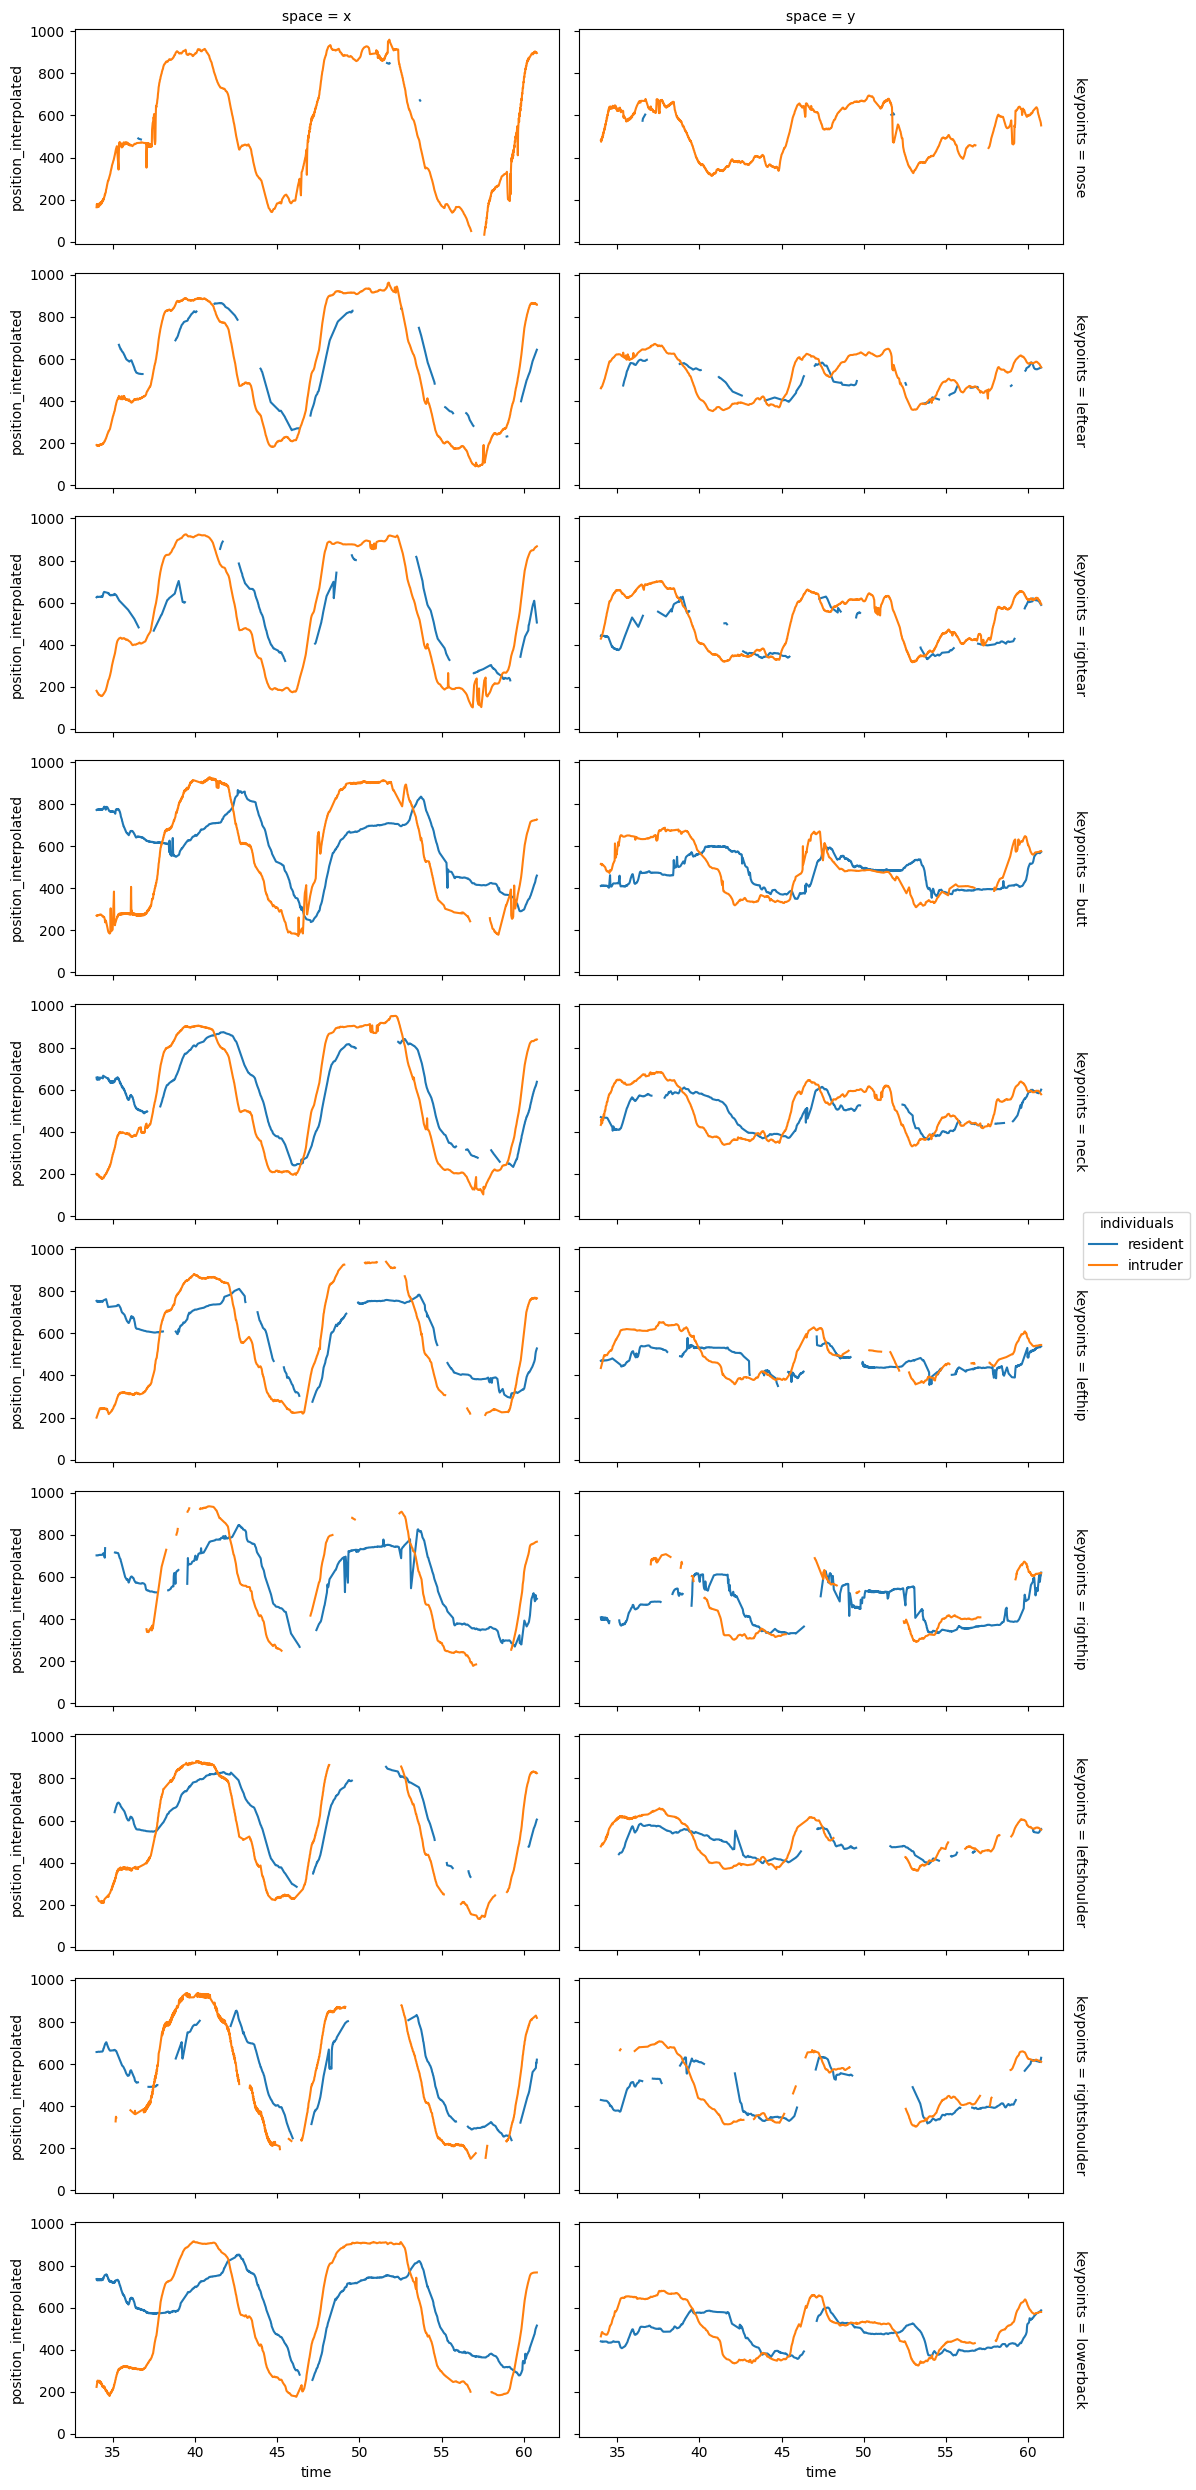

In [80]:
ds_new["position_interpolated"] = ds_new.move.interpolate_over_time(max_gap=25, data_vars=["position_thresholded"])
ds_new["position_interpolated"].plot.line(x="time", row="keypoints",  hue="individuals", col="space", aspect=2, size=2.5)
plt.savefig(plot_folder_1 / "SB019_female1_position_interpolated_threshold-80_max-gap-25.png")

Applying median filter to data with window and minimum period 


Missing points (marked as NaN) in input
	Individual: resident
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 0/1341 (0.0%)
		neck: 0/1341 (0.0%)
		lefthip: 0/1341 (0.0%)
		righthip: 0/1341 (0.0%)
		leftshoulder: 0/1341 (0.0%)
		rightshoulder: 0/1341 (0.0%)
		lowerback: 0/1341 (0.0%)
	Individual: intruder
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 0/1341 (0.0%)
		neck: 0/1341 (0.0%)
		lefthip: 0/1341 (0.0%)
		righthip: 0/1341 (0.0%)
		leftshoulder: 0/1341 (0.0%)
		rightshoulder: 0/1341 (0.0%)
		lowerback: 0/1341 (0.0%)

Missing points (marked as NaN) in output
	Individual: resident
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/1341 (0.0%)
		butt: 0/1341 (0.0%)
		neck: 0/1341 (0.0%)
		lefthip: 0/1341 (0.0%)
		righthip: 0/1341 (0.0%)
		leftshoulder: 0/1341 (0.0%)
		rightshoulder: 0/1341 (0.0%)
		lowerback: 0/1341 (0.0%)
	Individual: intruder
		nose: 0/1341 (0.0%)
		leftear: 0/1341 (0.0%)
		rightear: 0/

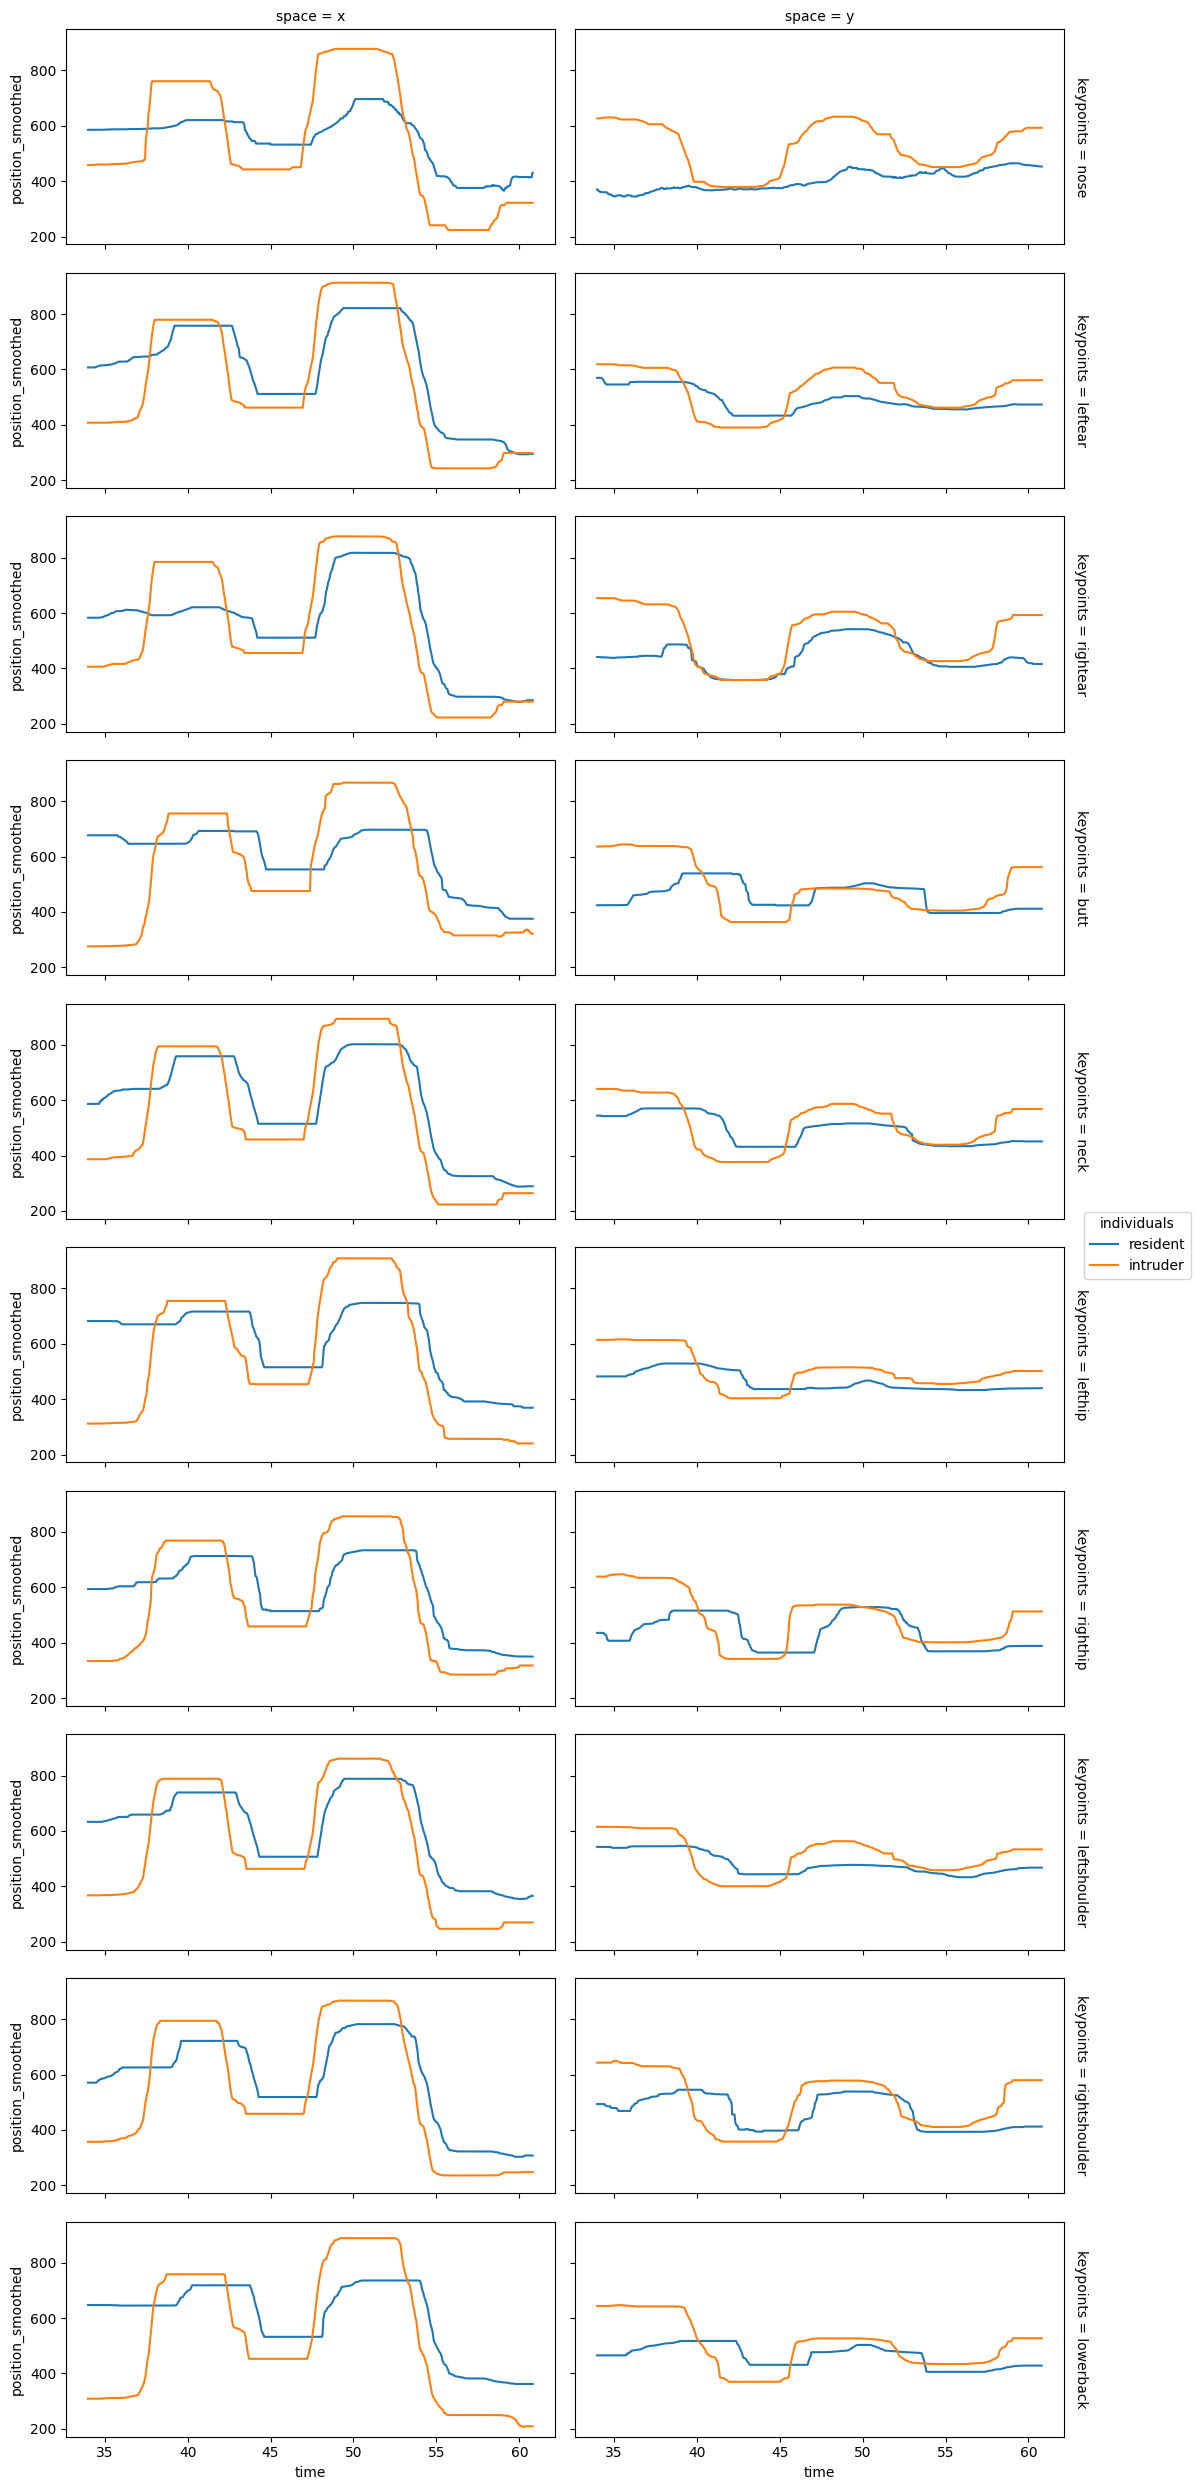

In [81]:
window = int(7 * ds_new.fps)
ds_new["position_smoothed"] = ds_new.move.median_filter(window, min_periods=2)
ds_new["position_smoothed"].plot.line(x="time", row="keypoints",  hue="individuals", col="space", aspect=2, size=2.5)
plt.savefig(plot_folder_2 / "SB019_female1_position_smoothed_threshold-80_max-gap-25.png")

Generating Nan report

In [82]:
    
clean_file_path = clean_data_folder / f"{file_name}_clean.csv"
save_poses.to_dlc_file(ds_new["position_smoothed"], clean_file_path, split_individuals=False,)
       
nan_report = report_nan_values(ds_new["position"], f"clean data for {file_name}")
with open(report_folder /  f"{file_name}_clean_nan_report.txt", "w") as f:f.write(nan_report)


NameError: name 'save_poses' is not defined